## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from datetime import datetime, time, timedelta

## Load Data

In [2]:
dfs=[]
for i in range(651):
    dfs.append(pd.read_csv('MachineVariables_Data/'+str(i)+'.csv'))

In [3]:
labels=pd.read_csv('ProductID_ClassLabel.csv')

## Data inspection and cleaning

### Labels

In [4]:
labels.head()

,Product_ID,Classification
0,0,Lumpy
1,1,Lumpy
2,2,Lumpy
3,3,Lumpy
4,4,Loose Wap


In [5]:
labels=labels.set_index('Product_ID') #Product_ID can serve as the index

In [6]:
labels.Classification.unique()#all the labels which are not 'Good' or 'Lighting' 
#should be replaced by 'Untidy'

array(['Lumpy', 'Loose Wap', 'Lighting', 'Offset', 'Good', 'Sloped'],
      dtype=object)

In [7]:
labels=labels.replace({'Lumpy' : 'Untidy', 'Loose Wap': 'Untidy', 'Offset' : 'Untidy', 
                'Good' : 'Tidy', 'Sloped' : 'Untidy'})

### Machine Variables Data

Now let's consider the Machine Variables Data, which we encoded in dfs.

Let us start by simplifying the names of the columns.

In [8]:
dfs[0].columns

Index(['Unnamed: 0', 'Time', 'Variable 1', 'Time.1', 'Variable 1.1', 'Time.2',
       'Variable 3', 'Time.3', 'Variable 4', 'Time.4', 'Variable 5', 'Time.5',
       'Variable 6', 'Time.6', 'Variable 7', 'Time.7', 'Variable 8', 'Time.8',
       'Variable 9', 'Time.9', 'Variable 10', 'Time.10', 'Variable 11',
       'Time.11', 'Variable 12', 'Time.12', 'Variable 13', 'Time.13',
       'Variable 14', 'Time.14', 'Variable 15', 'Time.15', 'Variable 16',
       'Time.16', 'Variable 17', 'Time.17', 'Variable 4097', 'Time.18',
       'Variable 4098'],
      dtype='object')

In [9]:
for i in range(len(dfs)):
    dfs[i] = dfs[i].rename(columns={'Unnamed: 0': 'NotUseful', 'Time' : 'Time1', 
                       'Time.1' : 'Time2', 'Time.2' : 'Time3',
                       'Time.3' : 'Time4', 'Time.4' : 'Time5',
                       'Time.5' : 'Time6', 'Time.6' : 'Time7',
                       'Time.7' : 'Time8', 'Time.8' : 'Time9',
                       'Time.9' : 'Time10', 'Time.10' : 'Time11',
                       'Time.11' : 'Time12', 'Time.12' : 'Time13',
                       'Time.13' : 'Time14', 'Time.14' : 'Time15',
                       'Time.15' : 'Time16', 'Time.16' : 'Time17',
                       'Time.17' : 'Time18', 'Time.18' : 'Time19',
                       'Variable 1' : 'var1', 'Variable 1.1' : 'var2',
                       'Variable 3' : 'var3', 'Variable 4' : 'var4',
                       'Variable 5' : 'var5', 'Variable 6' : 'var6',
                       'Variable 7' : 'var7', 'Variable 8' : 'var8',
                       'Variable 9' : 'var9', 'Variable 10' : 'var10',
                       'Variable 11' : 'var11', 'Variable 12' : 'var12',
                       'Variable 13' : 'var13', 'Variable 14' : 'var14',
                       'Variable 15' : 'var15', 'Variable 16' : 'var16',
                       'Variable 17' : 'var17'})

Let's drop column 'NotUseful'

In [10]:
for i in range(len(dfs)):
    dfs[i] = dfs[i].drop('NotUseful',axis=1)

Each variable is measured for a time duration corresponding to the column to its left.

Let's change the ordering of the columns, so as to match the ordering in the production line.
Variable 13 should come first, afterwards Variable 14 and so on.

Note: for some products, there are extra variables like Variable 4000 . These are sometimes present, sometimes not -- we will simply ignore them in our model.

In [11]:
for i in range(len(dfs)):
    dfs[i] = pd.concat([dfs[i].Time13, dfs[i].var13, dfs[i].Time14, dfs[i].var14, 
           dfs[i].Time15, dfs[i].var15, dfs[i].Time16, dfs[i].var16,
           dfs[i].Time17, dfs[i].var17, dfs[i].Time7, dfs[i].var7,
           dfs[i].Time8, dfs[i].var8, dfs[i].Time9, dfs[i].var9,
           dfs[i].Time10, dfs[i].var10, dfs[i].Time11, dfs[i].var11,
           dfs[i].Time12, dfs[i].var12, dfs[i].Time4, dfs[i].var4,
           dfs[i].Time5, dfs[i].var5, dfs[i].Time6, dfs[i].var6,
           dfs[i].Time3, dfs[i].var3, dfs[i].Time1, dfs[i].var1,
           dfs[i].Time2, dfs[i].var2],axis=1)

At each machine, the times recorded are all the same. Example: Time7 = Time8, Time1 = Time 2 and so on.

So, let's eliminate a lot of this redudant information.

In [12]:
for i in range(len(dfs)):
    dfs[i] = dfs[i].drop(['Time14', 'Time15', 'Time16',
                          'Time17', 'Time8', 'Time9',
                          'Time10', 'Time11', 'Time12',
                          'Time5', 'Time6', 'Time2',
                         ],axis=1)
    dfs[i] = dfs[i].rename(columns={'Time13': 'TimeM1', 'Time7': 'TimeM2',
                                    'Time4': 'TimeM3', 'Time3': 'TimeM4',
                                    'Time1': 'TimeM5'})

The precise clock times don't matter, what matter is the number of seconds elapsed during a given process.

The following code simplifies the Time columns. (this part of the code is messy, don't read in detail)

In [13]:
for i in range(len(dfs)):
    
    #register TimeM1
    
    times = dfs[i].TimeM1.map(lambda t: datetime.strptime(t, '%Y-%m-%d %H:%M:%S') 
                  if isinstance(t, str) else np.nan)
    dfs[i].TimeM1 = times.map(lambda t: (t-times.iloc[0]).seconds if isinstance(t, datetime)
                              else np.nan) 
    
    #register TimeM2

    times = dfs[i].TimeM2.map(lambda t: datetime.strptime(t, '%Y-%m-%d %H:%M:%S') 
                  if isinstance(t, str) else np.nan)
    dfs[i].TimeM2 = times.map(lambda t: (t-times.iloc[0]).seconds if isinstance(t, datetime)
                              else np.nan)
    
    #register TimeM3

    times = dfs[i].TimeM3.map(lambda t: datetime.strptime(t, '%Y-%m-%d %H:%M:%S') 
                  if isinstance(t, str) else np.nan)
    dfs[i].TimeM3 = times.map(lambda t: (t-times.iloc[0]).seconds if isinstance(t, datetime)
                              else np.nan)
    
    #register TimeM4

    times = dfs[i].TimeM4.map(lambda t: datetime.strptime(t, '%Y-%m-%d %H:%M:%S') 
                  if isinstance(t, str) else np.nan)
    dfs[i].TimeM4 = times.map(lambda t: (t-times.iloc[0]).seconds if isinstance(t, datetime)
                              else np.nan)
    
    #register TimeM5

    times = dfs[i].TimeM5.map(lambda t: datetime.strptime(t, '%Y-%m-%d %H:%M:%S') 
                  if isinstance(t, str) else np.nan)
    dfs[i].TimeM5 = times.map(lambda t: (t-times.iloc[0]).seconds if isinstance(t, datetime)
                              else np.nan)
    

## Exploratory Data Analysis and Feature Extraction

### Labels

Let's look at the labels distribution.

Let's start by removing the 'Lighting' products, since these won't matter to our analysis.

In [14]:
l = labels.loc[ (labels.Classification == 'Tidy') | (labels.Classification == 'Untidy')]
l.value_counts()

Classification
Untidy            356
Tidy              158
Name: count, dtype: int64

So, we see that there are more almost double 'Untidy' products than there are 'Tidy'. In this sense, our dataset is imbalanced and we might need to take this into account when modelling.

The 'Tidy' products seem to come in bunches, let's make a histogram to see if that's the case.

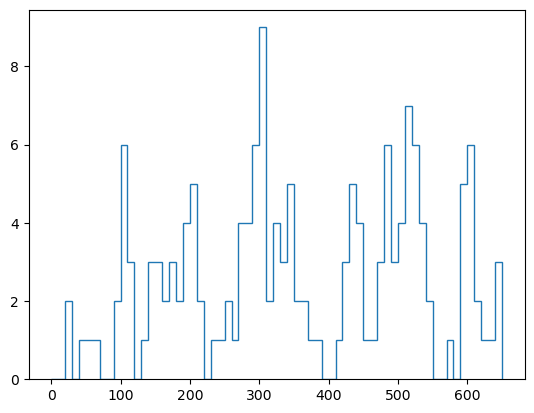

In [15]:
counts, bins = np.histogram( l.loc[ (l.Classification == 'Tidy') ].index.to_numpy(), np.arange(0,660,10))
plt.stairs(counts, bins)
del(counts, bins)

This histogram has many spikes which indicates that indeed the 'Tidy' products come in bunches.

Let's make this observation a little more precise. Given a random observation, the probability of getting 'Tidy' is equal to

number('Tidy')/ (number('Tidy') + number('Untidy') ) = 0.307

Let's study what the effect of having obtained 'Tidy' in a previous observation has on our current measurement.

In [16]:
l2 = l.copy()
l2['lag1'] = l2['Classification'].shift(1, fill_value = np.nan)
l2['lag2'] = l2['Classification'].shift(2, fill_value = np.nan)
l2['lag3'] = l2['Classification'].shift(3, fill_value = np.nan)
l2['lag4'] = l2['Classification'].shift(4, fill_value = np.nan)
l2['lag5'] = l2['Classification'].shift(5, fill_value = np.nan)

In [17]:
l2.loc[ l2.lag1 == 'Tidy'].Classification.value_counts()

Classification
Untidy    90
Tidy      67
Name: count, dtype: int64

So, if an observation returns 'Tidy', the probability the next observation returns 'Tidy' is equal to 67/(67+90) = 0.42 . This is higher than 0.3.

In [18]:
l2.loc[ (l2.lag1 == 'Tidy') & (l2.lag2 == 'Tidy')].Classification.value_counts()

Classification
Tidy      36
Untidy    31
Name: count, dtype: int64

So, if the two previous values are 'Tidy', the probability of getting 'Tidy' in the next measurement is equal to 0.54.

In [19]:
l2.loc[ (l2.lag1 == 'Tidy') & (l2.lag2 == 'Tidy') & (l2.lag3 == 'Tidy')].Classification.value_counts()

Classification
Tidy      25
Untidy    11
Name: count, dtype: int64

If we get 'Tidy' three times in a row, the probability of getting 'Tidy' in the next measurement is 0.7.

Clearly, the lag columns will be important features. Let's store them

In [20]:
features = pd.concat([l2.lag1, l2.lag2, l2.lag3, l2.lag4, l2.lag5], axis = 1)
del(l2)

### Machine Variables Data - Time Independent Part

Let's turn to the MachineVariables_data. Due to time-dependence, for every product we have a lot of information, corresponding to the measurements done at each second.

From this large amount of data, we need to select the most important features. This is what we will actually use to later train a model that performs binary classification.

Many of the variables hardly change during the production process. When they don't change, we should replace them by their mean.

For each variable describing each product for a duration of time, we will compute its standard deviation divided by its mean over the duration of time. This will give us a good understanding of whether the variable changes or not.

In [22]:
variables=['var13', 'var14', 'var15', 'var16', 'var17', 'var7',
       'var8', 'var9', 'var10', 'var11', 'var12', 'var4', 'var5',
       'var6', 'var3', 'var1', 'var2']

stats={}

for variable in variables:
    stats_var=[]
    
    for i in range(len(dfs)):
        std = dfs[i][variable].std()
        mean = dfs[i][variable].mean()
        
        if mean ==0.0:
            mean = 10**(-8) #avoid 0's in denominator
            
        std_normalised = abs(std/mean)
        
        stats_var.append(np.around(std_normalised,3))
        
    stats[variable] = np.array(stats_var)
    
stats=pd.DataFrame(stats)

stats['Classification'] = labels.Classification ## let's add the labels to these stats

For example:

In [23]:
stats.loc[ stats.var14 > 0.05 ]

,var13,var14,var15,var16,var17,var7,var8,var9,var10,var11,var12,var4,var5,var6,var3,var1,var2,Classification
456,0.0,1.634,1.713,0.027,0.061,0.0,0.0,0.0,1.634,1.045,0.000,0.0,0.0,0.0,0.0,0.0,0.0,Untidy
477,0.0,1.262,1.375,0.026,0.072,0.0,0.0,0.0,1.272,2.090,7.396,0.0,0.0,0.0,0.0,0.0,0.0,Tidy


So, only two times did var14 change by more than 5 %. For this reason, we can safely reduce it to its mean.

Note that during those two times something very abrupt must have happened, since the variation was more than 100%. These are outliers, and we will remove them.

By scanning through the variables we conclude that the following list of variables

In [24]:
vars_to_mean = ['var2', 'var3', 'var4', 'var5', 'var6', 'var7', 'var8', 'var9', 'var10', 'var13'
 , 'var14', 'var15', 'var16', 'var17']

can be safely replaced by their mean. These are the time independent variables.

Some outliers have their variables of type vars_to_mean changing with time. Let's identify them.

In [25]:
outliers = np.array([])
for i in range(len(vars_to_mean)):
    outliers = np.append(outliers, stats.loc[ stats[vars_to_mean[i]] > 0.5 ].index.to_numpy() )

outliers = np.unique(outliers).astype(int)
outliers

array([ 73,  85, 242, 254, 398, 402, 456, 477, 572, 585, 642])

Finally, let's compute the means of the time-independent variables.

In [26]:
df_means = pd.concat([pd.DataFrame([dfs[i][vars_to_mean].mean().round(2)], index = [i]) 
                      for i in range(len(dfs))], axis = 0)
df_means.head()

,var2,var3,var4,var5,var6,var7,var8,var9,var10,var13,var14,var15,var16,var17
0,1759.00,71.0,900.0,930.0,930.0,0.0,900.0,900.0,63.34,5.5,9.86,5.28,41.29,38.99
1,1759.00,71.0,900.0,930.0,930.0,0.0,900.0,900.0,63.84,5.5,9.94,5.29,42.54,40.68
2,1759.02,71.0,1400.0,930.0,930.0,0.0,1400.0,1400.0,64.00,5.5,9.96,5.40,41.75,39.24
3,1759.02,71.0,1400.0,930.0,930.0,0.0,1400.0,1400.0,66.78,5.5,10.30,6.32,41.32,37.55
4,1759.00,71.0,1400.0,930.0,930.0,0.0,1400.0,1400.0,66.78,5.5,10.30,6.33,40.44,36.08


Having obtained df_means let's join it to our features and remove outliers.

In [27]:
indx_to_drop = np.intersect1d(features.index.to_numpy(),outliers) #outlier indices

In [28]:
features_new = features.join(df_means.loc[features.index]).drop(indx_to_drop, axis = 0)

Let's see if some of the variables don't change much for all the products. If that's the case, let's drop them.

In [29]:
features_new[vars_to_mean].std() / features_new[vars_to_mean].mean()

var2     0.000013
var3     0.713261
var4     0.705653
var5     0.209302
var6     0.209301
var7     3.012222
var8     0.706370
var9     0.706519
var10    0.290112
var13    0.319863
var14    0.189262
var15    0.190289
var16    0.126013
var17    0.124341
dtype: float64

var2 doesn't change that much, we can drop it.

In [30]:
features_new = features_new.drop('var2', axis = 1)

There would be more outliers we could remove. For example:

In [32]:
features_new.var4.value_counts()

var4
1400.00    227
200.00     224
750.00      36
900.00      17
1255.23      1
1214.27      1
Name: count, dtype: int64

I suspect the last two values are outliers. I'm running out of time so I will leave removal of outliers for a future iteration.

## Correlated Variables

In [32]:
features_new[vars_to_mean[1:]].corr()

,var3,var4,var5,var6,var7,var8,var9,var10,var13,var14,var15,var16,var17
var3,1.000000,-0.004936,-0.001899,-0.001895,0.035640,0.004115,0.004403,0.025797,0.049661,0.099706,-0.059109,0.247406,-0.153048
var4,-0.004936,1.000000,0.950192,0.950190,-0.091289,0.988812,0.988724,-0.030064,-0.026858,-0.075904,-0.001524,-0.077278,-0.032270
var5,-0.001899,0.950192,1.000000,1.000000,0.173517,0.940869,0.940815,-0.223194,0.246662,-0.077232,0.054210,-0.165775,-0.103565
var6,-0.001895,0.950190,1.000000,1.000000,0.173520,0.940868,0.940814,-0.223187,0.246665,-0.077219,0.054224,-0.165766,-0.103554
var7,0.035640,-0.091289,0.173517,0.173520,1.000000,-0.086174,-0.086182,-0.699988,0.963726,-0.033747,0.202136,-0.374089,-0.343869
var8,0.004115,0.988812,0.940869,0.940868,-0.086174,1.000000,0.999990,-0.024391,-0.021997,-0.062742,0.012793,-0.073559,-0.028782
var9,0.004403,0.988724,0.940815,0.940814,-0.086182,0.999990,1.000000,-0.024473,-0.021919,-0.062779,0.012703,-0.073550,-0.029131
var10,0.025797,-0.030064,-0.223194,-0.223187,-0.699988,-0.024391,-0.024473,1.000000,-0.725811,0.712192,0.498074,0.603717,0.615472
var13,0.049661,-0.026858,0.246662,0.246665,0.963726,-0.021997,-0.021919,-0.725811,1.000000,-0.035082,0.198044,-0.410376,-0.378936
var14,0.099706,-0.075904,-0.077232,-0.077219,-0.033747,-0.062742,-0.062779,0.712192,-0.035082,1.000000,0.921183,0.463726,0.508751


We see that many variables are correlated. Let's calculate which.

In [33]:
features_corr = abs(features_new[vars_to_mean[1:]].corr() ) > 0.95
features_corr

,var3,var4,var5,var6,var7,var8,var9,var10,var13,var14,var15,var16,var17
var3,True,False,False,False,False,False,False,False,False,False,False,False,False
var4,False,True,True,True,False,True,True,False,False,False,False,False,False
var5,False,True,True,True,False,False,False,False,False,False,False,False,False
var6,False,True,True,True,False,False,False,False,False,False,False,False,False
var7,False,False,False,False,True,False,False,False,True,False,False,False,False
var8,False,True,False,False,False,True,True,False,False,False,False,False,False
var9,False,True,False,False,False,True,True,False,False,False,False,False,False
var10,False,False,False,False,False,False,False,True,False,False,False,False,False
var13,False,False,False,False,True,False,False,False,True,False,False,False,False
var14,False,False,False,False,False,False,False,False,False,True,False,False,False


Variables 4, 5, 6, 8, and 9 are all correlated with each other. 
So, let's drop columns.

In [34]:
features_not_corr = features_new.drop(['var5','var6','var8','var9'], axis = 1)

## Time Dependent Variables

In [35]:
vars_dependent = ['var1', 'var11', 'var12']

Let's plot these variables to try to get some intuition

Classification    Tidy
Name: 500, dtype: object


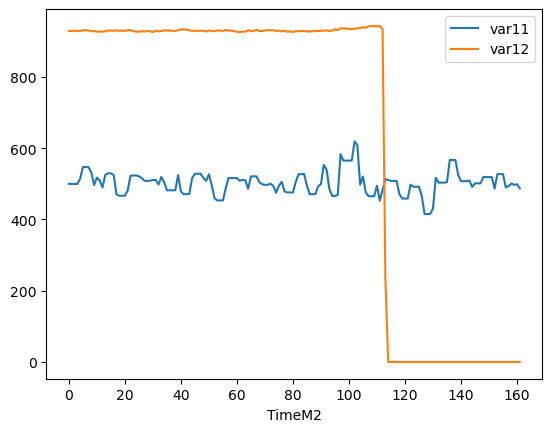

In [36]:
i = 500
print(labels.iloc[i])
dfs[i][['TimeM2', 'var11', 'var12']].set_index('TimeM2').plot()
del(i)

Classification    Untidy
Name: 100, dtype: object


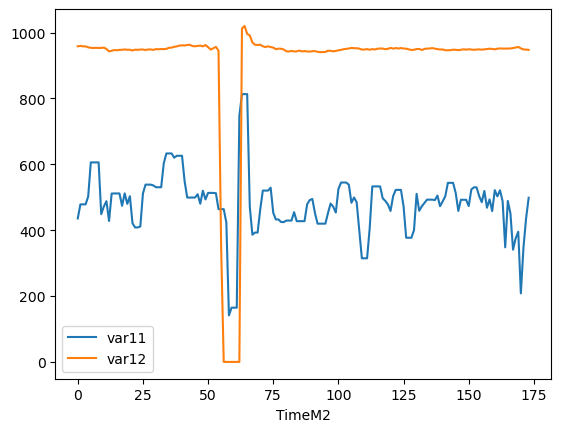

In [53]:
i = 100
print(labels.iloc[i])
dfs[i][['TimeM2', 'var11', 'var12']].set_index('TimeM2').plot()
del(i)

Classification    Untidy
Name: 200, dtype: object


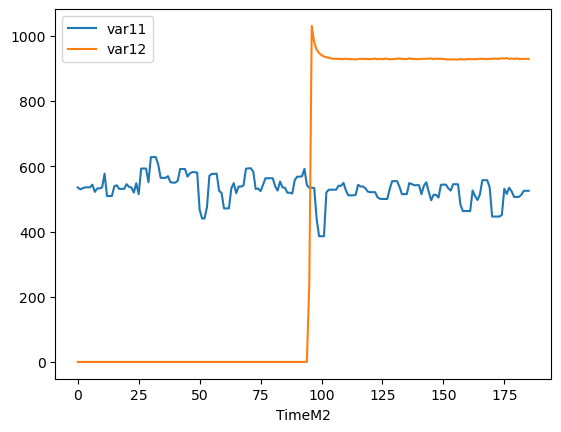

In [37]:
i = 200
print(labels.iloc[i])
dfs[i][['TimeM2', 'var11', 'var12']].set_index('TimeM2').plot()
del(i)

Classification    Tidy
Name: 300, dtype: object


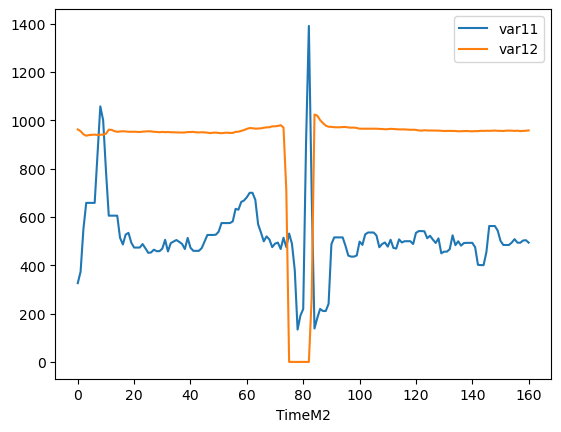

In [55]:
i = 300
print(labels.iloc[i])
dfs[i][['TimeM2', 'var11', 'var12']].set_index('TimeM2').plot()
del(i)

Classification    Untidy
Name: 400, dtype: object


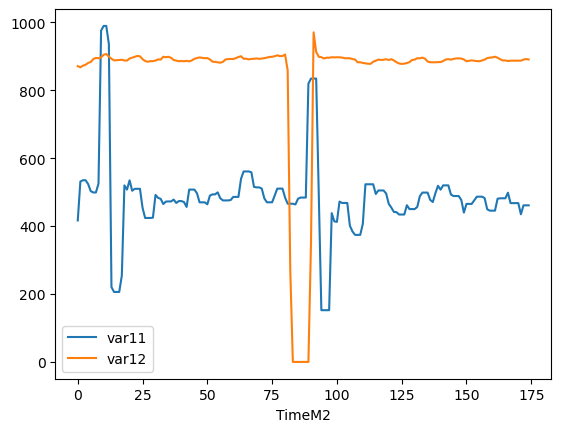

In [38]:
i = 400
print(labels.iloc[i])
dfs[i][['TimeM2', 'var11', 'var12']].set_index('TimeM2').plot()
del(i)

It is not clear to me what the pattern is. var1 seems to oscillate around its mean value, with one or two peaks per product. 
I will estimate var11 by its average value.
var12 is often a step function. I will estimate var12 by its last time value.
Let's plot var1 now.

Classification    Untidy
Name: 450, dtype: object


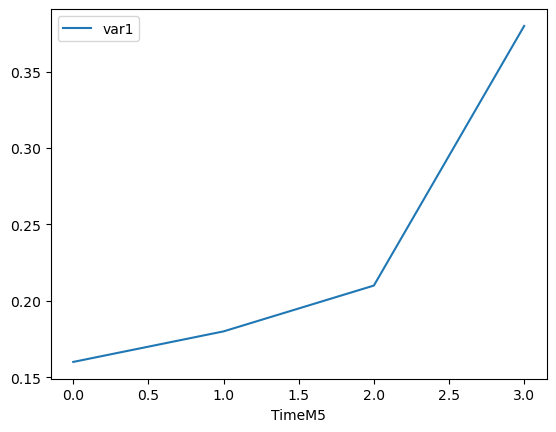

In [39]:
i = 450
print(labels.iloc[i])
dfs[i][['TimeM5', 'var1']].set_index('TimeM5').plot()
del(i)

Classification    Tidy
Name: 300, dtype: object


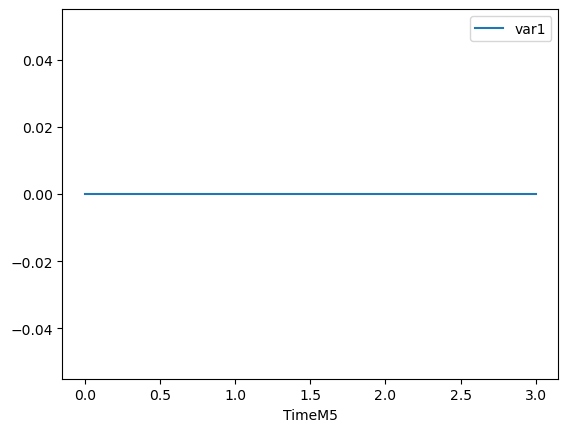

In [71]:
i = 300
print(labels.iloc[i])
dfs[i][['TimeM5', 'var1']].set_index('TimeM5').plot()
del(i)

Classification    Untidy
Name: 400, dtype: object


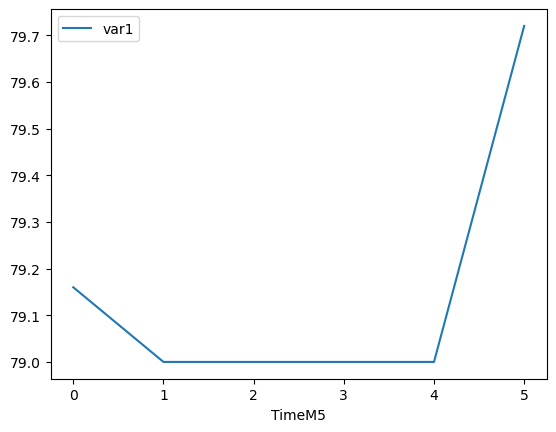

In [72]:
i = 400
print(labels.iloc[i])
dfs[i][['TimeM5', 'var1']].set_index('TimeM5').plot()
del(i)

Classification    Lighting
Name: 150, dtype: object


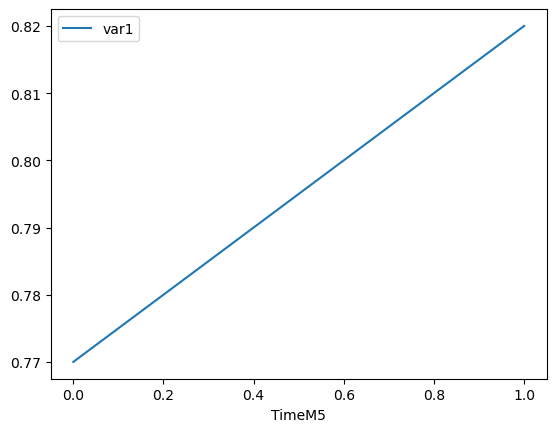

In [74]:
i = 150
print(labels.iloc[i])
dfs[i][['TimeM5', 'var1']].set_index('TimeM5').plot()
del(i)

I'm not sure what's the pattern in var1. I'm going to approximate it by its last value.

In [40]:
vars_dependent = ['var1', 'var11', 'var12']

stats_dep={}

#var11
stat = []
for i in range(len(dfs)):
    stat.append(dfs[i].var11.mean())
stats_dep['var11'] = np.array(stat)

#var12
stat = []
for i in range(len(dfs)):
    stat.append( dfs[i].var12.dropna().iloc[-1] )
stats_dep['var12'] = np.array(stat)

#var1
stat = []
for i in range(len(dfs)):
    stat.append( dfs[i].var1.dropna().iloc[-1] )
stats_dep['var1'] = np.array(stat)

features_dep = pd.DataFrame(stats_dep) # features involving the time dependent variables

In [41]:
features_dep.corr()

,var11,var12,var1
var11,1.000000,0.351625,-0.236423
var12,0.351625,1.000000,0.046621
var1,-0.236423,0.046621,1.000000


Let's join the time-dependent features with the others, to get the final set of features.

In [42]:
features_final = features_not_corr.join(features_dep.loc[features_not_corr.index])
labels_final = l.loc[features_final.index].replace({'Tidy' : 1, 'Untidy' : 0})

## ANOVA analysis 

Let's briefly examine which feature variables are more important for our classification problem.

In [70]:
data = features_final.join(labels_final)
var_table=['var3', 'var4', 'var7', 'var10',
       'var13', 'var14', 'var15', 'var16', 'var17', 'var11', 'var12', 'var1']

In [71]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

for var in var_table:
    
    model = ols('Classification ~ ' +var,                 # Model formula
            data = data).fit()
                
    anova_result = sm.stats.anova_lm(model, typ=2)
    print (anova_result)

              sum_sq     df          F    PR(>F)
var3        4.068350    1.0  19.674569  0.000011
Residual  104.218211  504.0        NaN       NaN
              sum_sq     df         F   PR(>F)
var4        0.708672    1.0  3.320113  0.06903
Residual  107.577889  504.0       NaN      NaN
              sum_sq     df         F    PR(>F)
var7        0.462566    1.0  2.162166  0.142069
Residual  107.823995  504.0       NaN       NaN
              sum_sq     df         F    PR(>F)
var10       1.235133    1.0  5.815026  0.016246
Residual  107.051429  504.0       NaN       NaN
              sum_sq     df         F    PR(>F)
var13       0.140817    1.0  0.656258  0.418266
Residual  108.145745  504.0       NaN       NaN
              sum_sq     df         F    PR(>F)
var14       1.449416    1.0  6.837563  0.009193
Residual  106.837145  504.0       NaN       NaN
              sum_sq     df         F    PR(>F)
var15       1.266965    1.0  5.966668  0.014921
Residual  107.019596  504.0       NaN   

Let's interpret these results. Higher P value implies that the null hypothesis is true, i.e the feature variable and the classification variable are independent.

So, the less important features for our model have higher P-values. These are var16 and var12.

Indeed we observe that

In [82]:
data[['var12','Classification']].value_counts()

var12   Classification
0.00    0                 128
        1                  56
949.00  0                   2
931.06  1                   2
930.14  0                   2
                         ... 
927.38  0                   1
927.30  1                   1
927.23  1                   1
927.15  0                   1
998.33  0                   1
Name: count, Length: 317, dtype: int64

## Model - Logistic Regression

Let's not use the categorical variables in the features, since we have a linear model.

In [43]:
features_no_cat = features_final.drop(['lag1','lag2','lag3','lag4','lag5'], axis = 1)

In [44]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(features_no_cat)
X = scaler.transform(features_no_cat) #normalization of the features

In [46]:
print([round(np.mean(X[:,i]),10) for i in range(len(X[0,:]))]) #0 mean
[round(np.std(X[:,i]),10) for i in range(len(X[0,:]))] # unit std

[-0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0]


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, labels_final.Classification.to_numpy(), 
                                                    test_size=0.25, random_state=10)

logreg = LogisticRegression(random_state=10)

# fit the model with data
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[81,  3],
       [41,  2]])

In [48]:
from sklearn import preprocessing

features_no_dep = features_no_cat.drop(['var1','var11','var12'], axis = 1)

scaler = preprocessing.StandardScaler().fit(features_no_dep)
X = scaler.transform(features_no_dep)

X_train, X_test, y_train, y_test = train_test_split(X, labels_final.Classification.to_numpy(), test_size=0.25, random_state=10)

logreg = LogisticRegression(random_state=10)

# fit the model with data
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[80,  4],
       [42,  1]])

## Model - Decision Trees

Let's include the categorical variables.

In [49]:
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
from sklearn.preprocessing import OrdinalEncoder

X_train, X_test, y_train, y_test = train_test_split(features_final, labels_final.Classification.to_numpy(),
                                                    test_size=0.2, random_state=10)


# Make copy to avoid changing original data 
label_X_train = X_train.copy()
label_X_test = X_test.copy()

cols_cat=['lag1','lag2','lag3','lag4','lag5'] #categorical variables

# Apply ordinal encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder()
label_X_train[cols_cat] = ordinal_encoder.fit_transform(X_train[cols_cat])
label_X_test[cols_cat] = ordinal_encoder.transform(X_test[cols_cat])

model= tree.DecisionTreeClassifier()

# fit the model with data
model.fit(label_X_train, y_train)

y_pred = model.predict(label_X_test)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[47, 21],
       [22, 12]])

## Model - Random Forests

In [84]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import OrdinalEncoder


# Define the models
model1 = RandomForestClassifier(n_estimators=50, random_state=0)
model2 = RandomForestClassifier(n_estimators=100, random_state=0)
model3 = RandomForestClassifier(n_estimators=200, random_state=0)
model4 = RandomForestClassifier(n_estimators=200, min_samples_split=20, random_state=0)
model5 = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(features_final.iloc[5:], labels_final.Classification.to_numpy()[5:],
                                                    test_size=0.2, random_state=10)

# Make copy to avoid changing original data 
label_X_train = X_train.copy()
label_X_test = X_test.copy()

cols_cat=['lag1','lag2','lag3','lag4','lag5']

# Apply ordinal encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder()
label_X_train[cols_cat] = ordinal_encoder.fit_transform(X_train[cols_cat])
label_X_test[cols_cat] = ordinal_encoder.transform(X_test[cols_cat])


# fit the models with data
model1.fit(label_X_train, y_train)
model2.fit(label_X_train, y_train)
model3.fit(label_X_train, y_train)
model4.fit(label_X_train, y_train)
model5.fit(label_X_train, y_train)

y1_pred = model1.predict(label_X_test)
y2_pred = model2.predict(label_X_test)
y3_pred = model3.predict(label_X_test)
y4_pred = model4.predict(label_X_test)
y5_pred = model5.predict(label_X_test)

cnf1_matrix = metrics.confusion_matrix(y_test, y1_pred)
print(cnf1_matrix)

cnf2_matrix = metrics.confusion_matrix(y_test, y2_pred)
print(cnf2_matrix)

cnf3_matrix = metrics.confusion_matrix(y_test, y3_pred)
print(cnf3_matrix)

cnf4_matrix = metrics.confusion_matrix(y_test, y4_pred)
print(cnf4_matrix)

cnf5_matrix = metrics.confusion_matrix(y_test, y5_pred)
print(cnf5_matrix)

[[61 12]
 [19  9]]
[[62 11]
 [18 10]]
[[60 13]
 [16 12]]
[[69  4]
 [17 11]]
[[64  9]
 [16 12]]


## Model - Random Forests - using just the categorical variable

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import OrdinalEncoder


# Define the models
model1 = RandomForestClassifier(n_estimators=50, random_state=0)
model2 = RandomForestClassifier(n_estimators=100, random_state=0)
model3 = RandomForestClassifier(n_estimators=200, random_state=0)
model4 = RandomForestClassifier(n_estimators=200, min_samples_split=20, random_state=0)
model5 = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=0)

cols_cat=['lag1','lag2','lag3','lag4','lag5']

X_train, X_test, y_train, y_test = train_test_split(features_final[cols_cat].iloc[5:], 
                                                    labels_final.Classification.to_numpy()[5:],
                                                    test_size=0.2, random_state=10)

# Make copy to avoid changing original data 
label_X_train = X_train.copy()
label_X_test = X_test.copy()

# Apply ordinal encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder()
label_X_train[cols_cat] = ordinal_encoder.fit_transform(X_train[cols_cat])
label_X_test[cols_cat] = ordinal_encoder.transform(X_test[cols_cat])


# instantiate the model (using the default parameters)

# fit the models with data
model1.fit(label_X_train, y_train)
model2.fit(label_X_train, y_train)
model3.fit(label_X_train, y_train)
model4.fit(label_X_train, y_train)
model5.fit(label_X_train, y_train)

y1_pred = model1.predict(label_X_test)
y2_pred = model2.predict(label_X_test)
y3_pred = model3.predict(label_X_test)
y4_pred = model4.predict(label_X_test)
y5_pred = model5.predict(label_X_test)

cnf1_matrix = metrics.confusion_matrix(y_test, y1_pred)
print(cnf1_matrix)

cnf2_matrix = metrics.confusion_matrix(y_test, y2_pred)
print(cnf2_matrix)

cnf3_matrix = metrics.confusion_matrix(y_test, y3_pred)
print(cnf3_matrix)

cnf4_matrix = metrics.confusion_matrix(y_test, y4_pred)
print(cnf4_matrix)

cnf5_matrix = metrics.confusion_matrix(y_test, y5_pred)
print(cnf5_matrix)

[[69  4]
 [20  8]]
[[70  3]
 [20  8]]
[[70  3]
 [20  8]]
[[70  3]
 [22  6]]
[[70  3]
 [20  8]]
